In [6]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

In [2]:
################################################
# 1️⃣ Chargement et Pré-traitement des Données #
################################################

# Charger les données MetroPT-3
df = pd.read_csv(r"..\..\..\Datasources\MetroPT3_new_imputed_final.csv", delimiter=",", decimal=".", index_col=0)
df.reset_index(drop=True, inplace=True)

# Sélection des features
continuous_features = ["TP2", "TP3", "H1", "DV_pressure", "Reservoirs","Oil_temperature","Motor_current"]
categorical_features = ["COMP", "DV_eletric","Towers","MPG","LPS","Pressure_switch","Oil_level","Caudal_impulses"]
features = continuous_features + categorical_features

# Conserver uniquement les colonnes utiles
df = df[["timestamp", "panne"] + features]

# Convertir timestamp en datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Standardisation des données (sans 'timestamp' ni 'panne')
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Sauvegarde du scaler pour réutilisation
joblib.dump(scaler, "scaler.pkl")

print("Prétraitement terminé avec succès !")

Prétraitement terminé avec succès !


In [3]:
# Dataset commence le 2020-04-12 11:20:00 et se termine le 2020-07-17 06:00:00
pannes = [
    {'id': 'Panne1',  'start': '2020-04-12 11:50:00', 'end': '2020-04-12 23:30:00'},
    {'id': 'Panne2',  'start': '2020-04-18 00:00:00', 'end': '2020-04-18 23:59:00'},
    {'id': 'Panne3',  'start': '2020-04-19 00:00:00', 'end': '2020-04-19 01:30:00'},
    {'id': 'Panne4',  'start': '2020-04-29 03:20:00', 'end': '2020-04-29 04:00:00'},
    {'id': 'Panne5',  'start': '2020-04-29 22:00:00', 'end': '2020-04-29 22:20:00'},
    {'id': 'Panne6',  'start': '2020-05-13 14:00:00', 'end': '2020-05-13 23:59:00'},
    {'id': 'Panne7',  'start': '2020-05-18 05:00:00', 'end': '2020-05-18 05:30:00'},
    {'id': 'Panne8',  'start': '2020-05-19 10:10:00', 'end': '2020-05-19 11:00:00'},
    {'id': 'Panne9',  'start': '2020-05-19 22:10:00', 'end': '2020-05-19 23:59:00'},
    {'id': 'Panne10', 'start': '2020-05-20 00:00:00', 'end': '2020-05-20 20:00:00'},
    {'id': 'Panne11', 'start': '2020-05-23 09:50:00', 'end': '2020-05-23 10:10:00'},
    {'id': 'Panne12', 'start': '2020-05-29 23:30:00', 'end': '2020-05-29 23:59:00'},
    {'id': 'Panne13', 'start': '2020-05-30 00:00:00', 'end': '2020-05-30 06:00:00'},
    {'id': 'Panne14', 'start': '2020-06-01 15:00:00', 'end': '2020-06-01 15:40:00'},
    {'id': 'Panne15', 'start': '2020-06-03 10:00:00', 'end': '2020-06-03 11:00:00'},
    {'id': 'Panne16', 'start': '2020-06-05 10:00:00', 'end': '2020-06-05 23:59:00'},
    {'id': 'Panne17', 'start': '2020-06-06 00:00:00', 'end': '2020-06-06 23:59:00'},
    {'id': 'Panne18', 'start': '2020-06-07 00:00:00', 'end': '2020-06-07 14:30:00'},
    {'id': 'Panne19', 'start': '2020-07-08 17:30:00', 'end': '2020-07-08 19:00:00'},
    {'id': 'Panne20', 'start': '2020-07-15 14:30:00', 'end': '2020-07-15 19:00:00'},
    {'id': 'Panne21', 'start': '2020-07-17 04:30:00', 'end': '2020-07-17 05:30:00'}
         ]

In [4]:
############################################
# 2️⃣ Séparation des Données en Train/Test #
###########################################

# Séparation des ensembles Train/Test
df_train = df[df["panne"] == 0].copy()  # Entraînement uniquement sur périodes normales
df_test  = df.copy()  # Test sur l’ensemble complet

# Extraction des données d’entraînement et de test
X_train = df_train[features].values
X_test  = df_test[features].values

print(f"Taille du Train : {X_train.shape[0]}, Taille du Test : {X_test.shape[0]}")

Taille du Train : 775911, Taille du Test : 827521


In [6]:
# Vérifier les cardinalité des variables discretes
var_a_verifier = ['panne']

print("----------------------------------")
for feature in var_a_verifier :
   print("Cardinalités de la variable ",feature,":")
   print(df[feature].value_counts())
   print("----------------------------------")
for feature in var_a_verifier :
   print("Cardinalités dans df_train de la variable ",feature,":")
   print(df_train[feature].value_counts())
   print("----------------------------------")
for feature in var_a_verifier :
   print("Cardinalités dans df_test de la variable  ",feature,":")
   print(df_test[feature].value_counts())
   print("----------------------------------")

----------------------------------
Cardinalités de la variable  panne :
0    775911
1     50145
2      1465
Name: panne, dtype: int64
----------------------------------
Cardinalités dans df_train de la variable  panne :
0    775911
Name: panne, dtype: int64
----------------------------------
Cardinalités dans df_test de la variable   panne :
0    775911
1     50145
2      1465
Name: panne, dtype: int64
----------------------------------


In [7]:
################################################################
# 3️⃣ Construction et Entrainement du Sparse Autoencoder (SAE) #
###############################################################

# Définition du modèle SAE
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation="relu")(input_layer)
encoder = Dense(64, activation="relu")(encoder)
encoder = Dense(32, activation="relu")(encoder)
bottleneck = Dense(12, activation="relu")(encoder)
decoder = Dense(32, activation="relu")(bottleneck)
decoder = Dense(64, activation="relu")(decoder)
decoder = Dense(128, activation="relu")(decoder)
output_layer = Dense(input_dim, activation="linear")(decoder)

sae = Model(input_layer, output_layer)
sae.compile(optimizer="adam", loss="mse")

print("Modèle SAE construit avec succès !")

# Entrainement du Modèle avec EarlyStopping
early_stopping = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

sae.fit(X_train, X_train, 
        epochs=100, 
        batch_size=32, 
        verbose=1, 
        callbacks=[early_stopping])

# Sauvegarde du modèle entraîné
sae.save(r"..\Generated_Files\SAE\sae_trained.keras")
print("Entrainement terminé avec EarlyStopping, modèle sauvegardé !")

Modèle SAE construit avec succès !
Epoch 1/100
24248/24248 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 0.0147
Epoch 2/100
24248/24248 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - loss: 0.0012
Epoch 3/100
24248/24248 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - loss: 8.0521e-04
Epoch 4/100
24248/24248 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - loss: 5.8085e-04
Epoch 5/100
24248/24248 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 6.0440e-04
Epoch 6/100
24248/24248 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 5.4088e-04
Epoch 7/100
24248/24248 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 4.4709e-04
Epoch 8/100
24248/24248 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 4.4075e-04
Epoch 9/100
24248/24248 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 4.7682e-04
Epoch 10/100
24248/24248 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 3.5249e-04
Epoch 11/100
24248/24248 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 3.7893e-04
Epoch 12/100
24248/24248 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 3.0539e-04
Epoch 13/100
24248/24248 ━━━━━━━━━━━━━━━━━━━━ 

In [5]:
###################################################
# 4️⃣ Détection des Anomalies sur l’Ensemble Test #
##################################################

# Charger le modèle entraîné
sae = tf.keras.models.load_model(r"..\Generated_Files\SAE\sae_trained.keras")

# Faire des prédictions sur l’ensemble test
X_reconstructed = sae.predict(X_test)

# Vérifier que la taille des sorties est correcte
assert X_reconstructed.shape == X_test.shape, "Erreur de dimension entre X_test et X_reconstructed"

# Calcul de l'erreur de reconstruction (MSE)
df_test["error"] = np.mean(np.square(X_test - X_reconstructed), axis=1)

25861/25861 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step


# TEST 1

In [9]:
# Définition du seuil d’anomalie 
mean_error = df_test["error"].mean()
std_error = df_test["error"].std()
threshold = mean_error + 1.2 * std_error

# Détection des anomalies
df_test["anomaly"] = df_test["error"] > threshold

# Afficher quelques stats
nb_anomalies = df_test["anomaly"].sum()
print(f"Nombre total d'anomalies détectées : {nb_anomalies}")
print(f"Seuil d'anomalie utilisé : {threshold:.6f}")

Nombre total d'anomalies détectées : 13314
Seuil d'anomalie utilisé : 0.007184


In [10]:
##############################################################
# 5️⃣ Vérification des Anomalies 15 minutes avant les Pannes #
#############################################################
anomalies_detectees = 0
total_pannes = len(pannes)

# Vérifier la détection des anomalies avant les pannes
anomalies_detectees = 0
total_pannes = len(pannes)
time_window = pd.Timedelta(minutes=15)

for panne in pannes:
    start_panne = pd.to_datetime(panne["start"])
    pre_panne = start_panne - time_window
    anomalies_avant_panne = df_test[(df_test["timestamp"] >= pre_panne) & 
                                    (df_test["timestamp"] < start_panne) & 
                                    (df_test["anomaly"])]
    
    if anomalies_avant_panne.shape[0] > 0:
        anomalies_detectees += 1
    print(f"Période avant panne {start_panne}: {anomalies_avant_panne.shape[0]} anomalies détectées")

# Correction du calcul des faux positifs
nb_total_anomalies = df_test["anomaly"].sum()
anomalies_hors_panne = df_test[(df_test["anomaly"]) & (df_test["panne"] == 0)]
taux_faux_positifs = anomalies_hors_panne.shape[0] / nb_total_anomalies * 100

# Affichage des résultats
print(f"-------------------------------------------------------------------")
print(f"Nombre total d’anomalies détectées : {nb_total_anomalies}")
print(f"Taux de détection des anomalies avant les pannes : {anomalies_detectees / total_pannes * 100:.2f}%") 
print(f"Taux de faux positifs : {taux_faux_positifs:.2f}%")
print(f"-------------------------------------------------------------------")

# Affichage des taux d’anomalies par catégorie de panne
taux_anomalies_par_panne = df_test.groupby("panne")["anomaly"].mean() * 100
df_taux_anomalies = pd.DataFrame({
    "Période (panne)": ["0 (Normal)", "1 (Panne)", "2 (Pré-Panne)"],
    "Taux d’anomalies détectées": [f"{taux_anomalies_par_panne[0]:.2f}%",
                                   f"{taux_anomalies_par_panne[1]:.2f}%",
                                   f"{taux_anomalies_par_panne[2]:.2f}%"]
})

# Affichage propre
print(df_taux_anomalies.to_string(index=False))

Période avant panne 2020-04-12 11:50:00: 0 anomalies détectées
Période avant panne 2020-04-18 00:00:00: 17 anomalies détectées
Période avant panne 2020-04-19 00:00:00: 5 anomalies détectées
Période avant panne 2020-04-29 03:20:00: 0 anomalies détectées
Période avant panne 2020-04-29 22:00:00: 0 anomalies détectées
Période avant panne 2020-05-13 14:00:00: 37 anomalies détectées
Période avant panne 2020-05-18 05:00:00: 0 anomalies détectées
Période avant panne 2020-05-19 10:10:00: 0 anomalies détectées
Période avant panne 2020-05-19 22:10:00: 0 anomalies détectées
Période avant panne 2020-05-20 00:00:00: 10 anomalies détectées
Période avant panne 2020-05-23 09:50:00: 0 anomalies détectées
Période avant panne 2020-05-29 23:30:00: 6 anomalies détectées
Période avant panne 2020-05-30 00:00:00: 11 anomalies détectées
Période avant panne 2020-06-01 15:00:00: 7 anomalies détectées
Période avant panne 2020-06-03 10:00:00: 0 anomalies détectées
Période avant panne 2020-06-05 10:00:00: 11 anomali

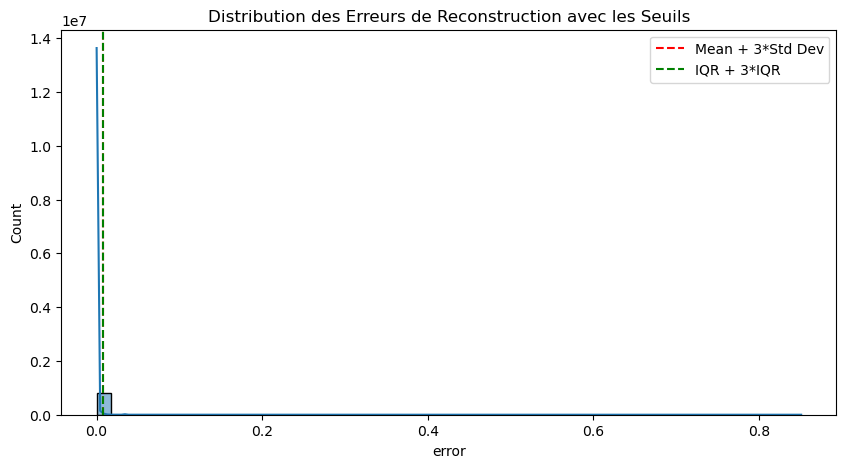

In [11]:
# Histogramme des erreurs de reconstruction

plt.figure(figsize=(10,5))
sns.histplot(df_test["error"], bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label="Mean + 3*Std Dev")
plt.axvline(threshold, color='g', linestyle='--', label="IQR + 3*IQR")
plt.legend()
plt.title("Distribution des Erreurs de Reconstruction avec les Seuils")
plt.show()

# TEST 2

In [12]:
# Définition du seuil d’anomalie 
# (IQR + 3*écart interquartile)
Q1 = df_test["error"].quantile(0.25)
Q3 = df_test["error"].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 2.7 * IQR

# Détection des anomalies
df_test["anomaly"] = df_test["error"] > threshold

# Afficher quelques stats
nb_anomalies = df_test["anomaly"].sum()
print(f"Nombre total d'anomalies détectées : {nb_anomalies}")
print(f"Seuil d'anomalie utilisé : {threshold:.6f}")

Nombre total d'anomalies détectées : 90035
Seuil d'anomalie utilisé : 0.000483


In [13]:
##############################################################
# 5️⃣ Vérification des Anomalies 15 minutes avant les Pannes #
#############################################################
anomalies_detectees = 0
total_pannes = len(pannes)

# Vérifier la détection des anomalies avant les pannes
anomalies_detectees = 0
total_pannes = len(pannes)
time_window = pd.Timedelta(minutes=15)

for panne in pannes:
    start_panne = pd.to_datetime(panne["start"])
    pre_panne = start_panne - time_window
    anomalies_avant_panne = df_test[(df_test["timestamp"] >= pre_panne) & 
                                    (df_test["timestamp"] < start_panne) & 
                                    (df_test["anomaly"])]
    
    if anomalies_avant_panne.shape[0] > 0:
        anomalies_detectees += 1
    print(f"Période avant panne {start_panne}: {anomalies_avant_panne.shape[0]} anomalies détectées")

# Correction du calcul des faux positifs
nb_total_anomalies = df_test["anomaly"].sum()
anomalies_hors_panne = df_test[(df_test["anomaly"]) & (df_test["panne"] == 0)]
taux_faux_positifs = anomalies_hors_panne.shape[0] / nb_total_anomalies * 100

# Affichage des résultats
print(f"-------------------------------------------------------------------")
print(f"Nombre total d’anomalies détectées : {nb_total_anomalies}")
print(f"Taux de détection des anomalies avant les pannes : {anomalies_detectees / total_pannes * 100:.2f}%") 
print(f"Taux de faux positifs : {taux_faux_positifs:.2f}%")
print(f"-------------------------------------------------------------------")

# Affichage des taux d’anomalies par catégorie de panne
taux_anomalies_par_panne = df_test.groupby("panne")["anomaly"].mean() * 100
df_taux_anomalies = pd.DataFrame({
    "Période (panne)": ["0 (Normal)", "1 (Panne)", "2 (Pré-Panne)"],
    "Taux d’anomalies détectées": [f"{taux_anomalies_par_panne[0]:.2f}%",
                                   f"{taux_anomalies_par_panne[1]:.2f}%",
                                   f"{taux_anomalies_par_panne[2]:.2f}%"]
})

# Affichage propre
print(df_taux_anomalies.to_string(index=False))

Période avant panne 2020-04-12 11:50:00: 0 anomalies détectées
Période avant panne 2020-04-18 00:00:00: 17 anomalies détectées
Période avant panne 2020-04-19 00:00:00: 90 anomalies détectées
Période avant panne 2020-04-29 03:20:00: 0 anomalies détectées
Période avant panne 2020-04-29 22:00:00: 19 anomalies détectées
Période avant panne 2020-05-13 14:00:00: 90 anomalies détectées
Période avant panne 2020-05-18 05:00:00: 33 anomalies détectées
Période avant panne 2020-05-19 10:10:00: 15 anomalies détectées
Période avant panne 2020-05-19 22:10:00: 5 anomalies détectées
Période avant panne 2020-05-20 00:00:00: 90 anomalies détectées
Période avant panne 2020-05-23 09:50:00: 44 anomalies détectées
Période avant panne 2020-05-29 23:30:00: 86 anomalies détectées
Période avant panne 2020-05-30 00:00:00: 90 anomalies détectées
Période avant panne 2020-06-01 15:00:00: 58 anomalies détectées
Période avant panne 2020-06-03 10:00:00: 0 anomalies détectées
Période avant panne 2020-06-05 10:00:00: 60 

# TEST 3

In [14]:
def low_pass_filter(data, alpha=0.05):
    filtered_data = []
    prev = data[0]  # Initialisation avec la première valeur
    for point in data:
        new_value = prev + alpha * (point - prev)
        filtered_data.append(new_value)
        prev = new_value
    return filtered_data

# Application du LPF sur l'erreur de reconstruction
df_test["filtered_error"] = low_pass_filter(df_test["error"], alpha=0.1)

# Recalcul du seuil basé sur l'erreur filtrée
Q1 = df_test["filtered_error"].quantile(0.25)
Q3 = df_test["filtered_error"].quantile(0.75)
IQR = Q3 - Q1
threshold_lpf = Q3 + 2.7 * IQR

# Détection des anomalies après application du LPF
df_test["anomaly_lpf"] = df_test["filtered_error"] > threshold_lpf

# Comparaison avec l'approche sans LPF
print(f"Anomalies détectées avec LPF : {df_test['anomaly_lpf'].sum()}")
print(f"Anomalies détectées sans LPF : {df_test['anomaly'].sum()}")

Anomalies détectées avec LPF : 99943
Anomalies détectées sans LPF : 90035


In [15]:
##############################################################
# 5️⃣ Vérification des Anomalies 15 minutes avant les Pannes #
#############################################################
anomalies_detectees = 0
total_pannes = len(pannes)

# Vérifier la détection des anomalies avant les pannes
anomalies_detectees = 0
total_pannes = len(pannes)
time_window = pd.Timedelta(minutes=15)

for panne in pannes:
    start_panne = pd.to_datetime(panne["start"])
    pre_panne = start_panne - time_window
    anomalies_avant_panne = df_test[(df_test["timestamp"] >= pre_panne) & 
                                    (df_test["timestamp"] < start_panne) & 
                                    (df_test["anomaly"])]
    
    if anomalies_avant_panne.shape[0] > 0:
        anomalies_detectees += 1
    print(f"Période avant panne {start_panne}: {anomalies_avant_panne.shape[0]} anomalies détectées")

# Correction du calcul des faux positifs
nb_total_anomalies = df_test["anomaly"].sum()
anomalies_hors_panne = df_test[(df_test["anomaly"]) & (df_test["panne"] == 0)]
taux_faux_positifs = anomalies_hors_panne.shape[0] / nb_total_anomalies * 100

# Affichage des résultats
print(f"-------------------------------------------------------------------")
print(f"Nombre total d’anomalies détectées : {nb_total_anomalies}")
print(f"Taux de détection des anomalies avant les pannes : {anomalies_detectees / total_pannes * 100:.2f}%") 
print(f"Taux de faux positifs : {taux_faux_positifs:.2f}%")
print(f"-------------------------------------------------------------------")

# Affichage des taux d’anomalies par catégorie de panne
taux_anomalies_par_panne = df_test.groupby("panne")["anomaly"].mean() * 100
df_taux_anomalies = pd.DataFrame({
    "Période (panne)": ["0 (Normal)", "1 (Panne)", "2 (Pré-Panne)"],
    "Taux d’anomalies détectées": [f"{taux_anomalies_par_panne[0]:.2f}%",
                                   f"{taux_anomalies_par_panne[1]:.2f}%",
                                   f"{taux_anomalies_par_panne[2]:.2f}%"]
})

# Affichage propre
print(df_taux_anomalies.to_string(index=False))

Période avant panne 2020-04-12 11:50:00: 0 anomalies détectées
Période avant panne 2020-04-18 00:00:00: 17 anomalies détectées
Période avant panne 2020-04-19 00:00:00: 90 anomalies détectées
Période avant panne 2020-04-29 03:20:00: 0 anomalies détectées
Période avant panne 2020-04-29 22:00:00: 19 anomalies détectées
Période avant panne 2020-05-13 14:00:00: 90 anomalies détectées
Période avant panne 2020-05-18 05:00:00: 33 anomalies détectées
Période avant panne 2020-05-19 10:10:00: 15 anomalies détectées
Période avant panne 2020-05-19 22:10:00: 5 anomalies détectées
Période avant panne 2020-05-20 00:00:00: 90 anomalies détectées
Période avant panne 2020-05-23 09:50:00: 44 anomalies détectées
Période avant panne 2020-05-29 23:30:00: 86 anomalies détectées
Période avant panne 2020-05-30 00:00:00: 90 anomalies détectées
Période avant panne 2020-06-01 15:00:00: 58 anomalies détectées
Période avant panne 2020-06-03 10:00:00: 0 anomalies détectées
Période avant panne 2020-06-05 10:00:00: 60 

# TEST 4

In [16]:
def low_pass_filter(data, alpha=0.05):
    """
    Applique un filtre passe-bas (LPF) sur les erreurs de reconstruction.
    
    data : Série d'erreurs à filtrer
    alpha : Facteur de lissage (0 < alpha < 1, plus c'est bas, plus le lissage est fort)
    
    Retourne :
    - Un tableau filtré des erreurs lissées
    """
    filtered_data = []
    prev = data[0]  # Initialisation avec la première valeur
    for point in data:
        new_value = prev + alpha * (point - prev)
        filtered_data.append(new_value)
        prev = new_value
    return filtered_data

# Application du LPF sur l'erreur de reconstruction
df_test["filtered_error"] = low_pass_filter(df_test["error"], alpha=0.1)

# Recalcul du seuil basé sur l'erreur filtrée
Q1 = df_test["filtered_error"].quantile(0.25)
Q3 = df_test["filtered_error"].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 2.7 * IQR

# Détection des anomalies après application du LPF
df_test["anomaly_lpf"] = df_test["filtered_error"] > threshold

# Comparaison avec l'approche sans LPF
print(f"Anomalies détectées avec LPF : {df_test['anomaly_lpf'].sum()}")
print(f"Anomalies détectées sans LPF : {df_test['anomaly'].sum()}")

Anomalies détectées avec LPF : 99943
Anomalies détectées sans LPF : 90035


In [17]:
##############################################################
# 5️⃣ Vérification des Anomalies 30 minutes avant les Pannes #
#############################################################
anomalies_detectees = 0
total_pannes = len(pannes)

# Vérifier la détection des anomalies avant les pannes
anomalies_detectees = 0
total_pannes = len(pannes)
time_window = pd.Timedelta(minutes=30)

for panne in pannes:
    start_panne = pd.to_datetime(panne["start"])
    pre_panne = start_panne - time_window
    anomalies_avant_panne = df_test[(df_test["timestamp"] >= pre_panne) & 
                                    (df_test["timestamp"] < start_panne) & 
                                    (df_test["anomaly"])]
    
    if anomalies_avant_panne.shape[0] > 0:
        anomalies_detectees += 1
    print(f"Période avant panne {start_panne}: {anomalies_avant_panne.shape[0]} anomalies détectées")

# Correction du calcul des faux positifs
nb_total_anomalies = df_test["anomaly"].sum()
anomalies_hors_panne = df_test[(df_test["anomaly"]) & (df_test["panne"] == 0)]
taux_faux_positifs = anomalies_hors_panne.shape[0] / nb_total_anomalies * 100

# Affichage des résultats
print(f"-------------------------------------------------------------------")
print(f"Nombre total d’anomalies détectées : {nb_total_anomalies}")
print(f"Taux de détection des anomalies avant les pannes : {anomalies_detectees / total_pannes * 100:.2f}%") 
print(f"Taux de faux positifs : {taux_faux_positifs:.2f}%")
print(f"-------------------------------------------------------------------")

# Affichage des taux d’anomalies par catégorie de panne
taux_anomalies_par_panne = df_test.groupby("panne")["anomaly"].mean() * 100
df_taux_anomalies = pd.DataFrame({
    "Période (panne)": ["0 (Normal)", "1 (Panne)", "2 (Pré-Panne)"],
    "Taux d’anomalies détectées": [f"{taux_anomalies_par_panne[0]:.2f}%",
                                   f"{taux_anomalies_par_panne[1]:.2f}%",
                                   f"{taux_anomalies_par_panne[2]:.2f}%"]
})

# Affichage propre
print(df_taux_anomalies.to_string(index=False))

Période avant panne 2020-04-12 11:50:00: 21 anomalies détectées
Période avant panne 2020-04-18 00:00:00: 34 anomalies détectées
Période avant panne 2020-04-19 00:00:00: 180 anomalies détectées
Période avant panne 2020-04-29 03:20:00: 23 anomalies détectées
Période avant panne 2020-04-29 22:00:00: 21 anomalies détectées
Période avant panne 2020-05-13 14:00:00: 96 anomalies détectées
Période avant panne 2020-05-18 05:00:00: 36 anomalies détectées
Période avant panne 2020-05-19 10:10:00: 19 anomalies détectées
Période avant panne 2020-05-19 22:10:00: 9 anomalies détectées
Période avant panne 2020-05-20 00:00:00: 180 anomalies détectées
Période avant panne 2020-05-23 09:50:00: 52 anomalies détectées
Période avant panne 2020-05-29 23:30:00: 86 anomalies détectées
Période avant panne 2020-05-30 00:00:00: 180 anomalies détectées
Période avant panne 2020-06-01 15:00:00: 71 anomalies détectées
Période avant panne 2020-06-03 10:00:00: 7 anomalies détectées
Période avant panne 2020-06-05 10:00:00

# TEST 5

In [18]:
time_window = pd.Timedelta(minutes=30)

for k in [2.0,2.7, 3.0, 3.5, 4.0, 4.5, 5.0,6.0, 7.0]:
    threshold = Q3 + k * IQR
    df_test[f"anomaly_lpf_k{k}"] = df_test["filtered_error"] > threshold

    anomalies_detectees = 0
    for panne in pannes:
        start_panne = pd.to_datetime(panne["start"])
        pre_panne = start_panne - time_window
        anomalies_avant_panne = df_test[(df_test["timestamp"] >= pre_panne) & 
                                        (df_test["timestamp"] < start_panne) & 
                                        (df_test[f"anomaly_lpf_k{k}"])]
        if anomalies_avant_panne.shape[0] > 0:
            anomalies_detectees += 1

    taux_detection_pannes = anomalies_detectees / len(pannes) * 100
    taux_faux_positifs = df_test[(df_test[f"anomaly_lpf_k{k}"]) & (df_test["panne"] == 0)].shape[0] / df_test[f"anomaly_lpf_k{k}"].sum() * 100

    print(f"k={k} -> Détection des pannes : {taux_detection_pannes:.2f}%, Faux positifs : {taux_faux_positifs:.2f}%")


k=2.0 -> Détection des pannes : 80.95%, Faux positifs : 54.26%
k=2.7 -> Détection des pannes : 80.95%, Faux positifs : 51.40%
k=3.0 -> Détection des pannes : 80.95%, Faux positifs : 50.43%
k=3.5 -> Détection des pannes : 80.95%, Faux positifs : 49.01%
k=4.0 -> Détection des pannes : 80.95%, Faux positifs : 47.67%
k=4.5 -> Détection des pannes : 80.95%, Faux positifs : 46.31%
k=5.0 -> Détection des pannes : 80.95%, Faux positifs : 44.93%
k=6.0 -> Détection des pannes : 80.95%, Faux positifs : 42.27%
k=7.0 -> Détection des pannes : 80.95%, Faux positifs : 39.72%


In [19]:
def low_pass_filter(data, alpha=0.05):
    filtered_data = []
    prev = data[0]  # Initialisation avec la première valeur
    for point in data:
        new_value = prev + alpha * (point - prev)
        filtered_data.append(new_value)
        prev = new_value
    return filtered_data

# Application du LPF sur l'erreur de reconstruction
df_test["filtered_error"] = low_pass_filter(df_test["error"], alpha=0.1)

# Recalcul du seuil basé sur l'erreur filtrée
Q1 = df_test["filtered_error"].quantile(0.25)
Q3 = df_test["filtered_error"].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 15 * IQR


# Détection des anomalies après application du LPF
df_test["anomaly_lpf"] = df_test["filtered_error"] > threshold

# Comparaison avec l'approche sans LPF
print(f"Anomalies détectées avec LPF : {df_test['anomaly_lpf'].sum()}")
print(f"Anomalies détectées sans LPF : {df_test['anomaly'].sum()}")

Anomalies détectées avec LPF : 65187
Anomalies détectées sans LPF : 90035


In [20]:
##############################################################
# 5️⃣ Vérification des Anomalies 30 minutes avant les Pannes #
#############################################################
anomalies_detectees = 0
total_pannes = len(pannes)

# Vérifier la détection des anomalies avant les pannes
anomalies_detectees = 0
total_pannes = len(pannes)
time_window = pd.Timedelta(minutes=30)

for panne in pannes:
    start_panne = pd.to_datetime(panne["start"])
    pre_panne = start_panne - time_window
    anomalies_avant_panne = df_test[(df_test["timestamp"] >= pre_panne) & 
                                    (df_test["timestamp"] < start_panne) & 
                                    (df_test["anomaly"])]
    
    if anomalies_avant_panne.shape[0] > 0:
        anomalies_detectees += 1
    print(f"Période avant panne {start_panne}: {anomalies_avant_panne.shape[0]} anomalies détectées")

# Correction du calcul des faux positifs
nb_total_anomalies = df_test["anomaly"].sum()
anomalies_hors_panne = df_test[(df_test["anomaly"]) & (df_test["panne"] == 0)]
taux_faux_positifs = anomalies_hors_panne.shape[0] / nb_total_anomalies * 100

# Affichage des résultats
print(f"-------------------------------------------------------------------")
print(f"Nombre total d’anomalies détectées : {nb_total_anomalies}")
print(f"Taux de détection des anomalies avant les pannes : {anomalies_detectees / total_pannes * 100:.2f}%") 
print(f"Taux de faux positifs : {taux_faux_positifs:.2f}%")
print(f"-------------------------------------------------------------------")

# Affichage des taux d’anomalies par catégorie de panne
taux_anomalies_par_panne = df_test.groupby("panne")["anomaly"].mean() * 100
df_taux_anomalies = pd.DataFrame({
    "Période (panne)": ["0 (Normal)", "1 (Panne)", "2 (Pré-Panne)"],
    "Taux d’anomalies détectées": [f"{taux_anomalies_par_panne[0]:.2f}%",
                                   f"{taux_anomalies_par_panne[1]:.2f}%",
                                   f"{taux_anomalies_par_panne[2]:.2f}%"]
})

# Affichage propre
print(df_taux_anomalies.to_string(index=False))

Période avant panne 2020-04-12 11:50:00: 21 anomalies détectées
Période avant panne 2020-04-18 00:00:00: 34 anomalies détectées
Période avant panne 2020-04-19 00:00:00: 180 anomalies détectées
Période avant panne 2020-04-29 03:20:00: 23 anomalies détectées
Période avant panne 2020-04-29 22:00:00: 21 anomalies détectées
Période avant panne 2020-05-13 14:00:00: 96 anomalies détectées
Période avant panne 2020-05-18 05:00:00: 36 anomalies détectées
Période avant panne 2020-05-19 10:10:00: 19 anomalies détectées
Période avant panne 2020-05-19 22:10:00: 9 anomalies détectées
Période avant panne 2020-05-20 00:00:00: 180 anomalies détectées
Période avant panne 2020-05-23 09:50:00: 52 anomalies détectées
Période avant panne 2020-05-29 23:30:00: 86 anomalies détectées
Période avant panne 2020-05-30 00:00:00: 180 anomalies détectées
Période avant panne 2020-06-01 15:00:00: 71 anomalies détectées
Période avant panne 2020-06-03 10:00:00: 7 anomalies détectées
Période avant panne 2020-06-05 10:00:00

In [27]:
print(df_normal.columns)  # Vérifie toutes les colonnes disponibles


Index(['timestamp', 'panne', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses',
       'error'],
      dtype='object')


Importance des Features selon Random Forest :
DV_pressure        0.518732
Oil_temperature    0.125575
Motor_current      0.107653
H1                 0.084983
TP3                0.057738
Reservoirs         0.056867
TP2                0.044833
Towers             0.002961
LPS                0.000263
Oil_level          0.000135
Pressure_switch    0.000083
COMP               0.000062
MPG                0.000049
DV_eletric         0.000036
Caudal_impulses    0.000031
dtype: float64


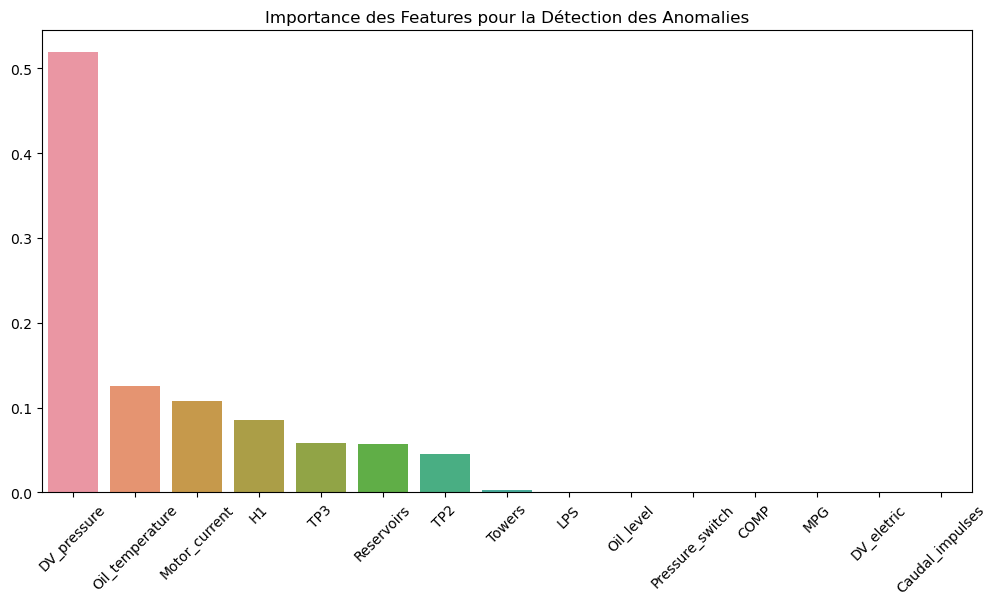

In [26]:
###############################################################
# 6️⃣ Importance des Features pour la Détection des Anomalies#
#############################################################
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Vérification et création de la colonne 'error' si elle n'existe pas
if "error" not in df.columns:
    df["error"] = df["DV_pressure"].diff().abs()  # Exemple : variation absolue de la pression

# Remplacer les NaN dans "error"
df["error"] = df["error"].fillna(0)  # Alternative : df["error"].fillna(df["error"].median())

# Sélectionner uniquement les périodes normales
df_normal = df[df["panne"] == 0]

# Définir les features (enlever "panne" et "timestamp" si présent)
features = [col for col in df.columns if col not in ["panne", "timestamp", "error"]]

# Entraîner le modèle Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(df_normal[features], df_normal["error"])  # Utiliser "error" comme variable cible

# Récupérer l’importance des features
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

# Affichage des résultats
print("Importance des Features selon Random Forest :")
print(importances)

# Visualisation
plt.figure(figsize=(12,6))
sns.barplot(x=importances.index, y=importances.values)
plt.xticks(rotation=45)
plt.title("Importance des Features pour la Détection des Anomalies")
plt.show()


In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

# Définition de la fenêtre avant panne (optimale = 30 min)
time_window = pd.Timedelta(minutes=30)

# Vérification et création de la colonne 'error' si elle n'existe pas
if "error" not in df.columns:
    df["error"] = df["DV_pressure"].diff().abs()  # Exemple : variation absolue de la pression
   
# Remplacer les NaN dans "error"
df["error"] = df["error"].fillna(0)

# **Appliquer un Filtre Passe-Bas (LPF)**
def low_pass_filter(data, alpha=0.1):
    filtered_data = []
    prev = data.iloc[0]  # Utilisation du premier élément comme valeur initiale
    for point in data:
        new_value = prev + alpha * (point - prev)
        filtered_data.append(new_value)
        prev = new_value
    return pd.Series(filtered_data, index=data.index)

# Appliquer le filtre LPF sur l’erreur détectée
df["filtered_error"] = low_pass_filter(df["error"], alpha=0.1)

# Itération sur plusieurs valeurs de k
k_values = [5,10,20,30,40,50,60,70,80,90,100]

for k in k_values:
    # **Définition du seuil optimal pour k**
    Q1 = df["filtered_error"].quantile(0.25)
    Q3 = df["filtered_error"].quantile(0.75)
    IQR = Q3 - Q1
    threshold = Q3 + k * IQR  # Seuil ajusté

    # **Détection des anomalies après application du LPF**
    df["anomaly"] = df["filtered_error"] > threshold

    # **Analyse des performances**
    total_anomalies = df["anomaly"].sum()
    anomalies_avant_panne = 0
    detection_avant_panne = {}

    # Analyse des anomalies avant chaque panne avec une fenêtre de 30 min
    for panne in pannes:
        start_panne = pd.to_datetime(panne["start"])
        pre_panne = start_panne - time_window
        
        # Filtrer les anomalies détectées dans la période avant la panne
        anomalies = df[(df["timestamp"] >= pre_panne) & (df["timestamp"] < start_panne) & (df["anomaly"])]
        nb_anomalies = anomalies.shape[0]
        
        detection_avant_panne[start_panne] = nb_anomalies
        anomalies_avant_panne += (nb_anomalies > 0)

    # Calcul des taux
    taux_detection_pannes = (anomalies_avant_panne / len(pannes)) * 100
    taux_faux_positifs = df[(df["anomaly"]) & (df["panne"] == 0)].shape[0] / total_anomalies * 100

    # **Calcul des métriques de classification**
    y_true = df["panne"] > 0  # 1 si panne, 0 sinon
    y_pred = df["anomaly"]  # 1 si anomalie détectée, 0 sinon

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # **Courbe ROC et AUC**
    fpr, tpr, _ = roc_curve(y_true, df["filtered_error"])
    roc_auc = auc(fpr, tpr)

    # **Comptage des anomalies par type de période**
    anomalies_par_type = df.groupby("panne")["anomaly"].mean() * 100

    # **Affichage des résultats pour k**
    print("##########################")
    print(f"Résultats pour k = {k}")
    #for start_panne, nb_anomalies in detection_avant_panne.items():
        #print(f"Période avant panne {start_panne}: {nb_anomalies} anomalies détectées")
    
    print("##########################")
    print(f"Nombre total d’anomalies détectées : {total_anomalies}")
    print(f"Taux de détection des anomalies avant les pannes : {taux_detection_pannes:.2f}%")
    print(f"Taux de faux positifs : {taux_faux_positifs:.2f}%")
    print("-------------------------------------------------------------------")
    print(f"**Métriques de classification**")
    print(f"Précision : {precision:.2f}")
    print(f"Rappel : {recall:.2f}")
    print(f"Score F1 : {f1:.2f}")
    print(f"AUC ROC : {roc_auc:.2f}")
    print("-------------------------------------------------------------------")
    
    # **Affichage des taux d’anomalies par type de période**
    print("Période (panne)  Taux d’anomalies détectées")
    for key, value in anomalies_par_type.items():
        label = "Normal" if key == 0 else "Panne" if key == 1 else "Pré-Panne"
        print(f"     {key} ({label})                      {value:.2f}%")
    print("-------------------------------------------------------------------\n")


##########################
Résultats pour k = 5
##########################
Nombre total d’anomalies détectées : 155456
Taux de détection des anomalies avant les pannes : 76.19%
Taux de faux positifs : 70.22%
-------------------------------------------------------------------
**Métriques de classification**
Précision : 0.30
Rappel : 0.90
Score F1 : 0.45
AUC ROC : 0.92
-------------------------------------------------------------------
Période (panne)  Taux d’anomalies détectées
     0 (Normal)                      14.07%
     1 (Panne)                      91.28%
     2 (Pré-Panne)                      35.36%
-------------------------------------------------------------------

##########################
Résultats pour k = 10
##########################
Nombre total d’anomalies détectées : 145001
Taux de détection des anomalies avant les pannes : 76.19%
Taux de faux positifs : 68.12%
-------------------------------------------------------------------
**Métriques de classification**
Précis

In [ ]:
Sélection du meilleur modèle
 k	Précision	Rappel	Score F1	Taux de faux positifs	Taux de détection pré-panne
 5	0.30		0.90	0.45		70.22%					35.36%
10	0.32		0.90	0.47		68.12%					34.95%
20	0.57		0.89	0.69		43.46%					28.40%
30	0.61		0.89	0.72		39.17%					28.19%
40	0.64		0.89	0.74		36.22%					28.19%
50	0.66		0.89	0.76		33.85%					28.19%
60	0.68		0.88	0.77		31.96%					28.19%
70	0.69		0.86	0.77		30.60%					28.05%
80	0.70		0.82	0.76		29.90%					27.58%
90	0.70		0.77	0.74		29.69%					26.48%
100	0.70		0.71	0.70		30.03%					25.05%


Meilleur compromis : k = 60

-Précision élevée (0.68), donc moins de fausses alertes.
-Rappel encore bon (0.88), donc toujours une bonne détection des pannes.
-Score F1 optimal (0.77), ce qui signifie un bon équilibre entre précision et rappel.
-Taux de faux positifs réduit à 31.96%, bien inférieur aux versions avec k plus bas.
-Taux de détection pré-panne stable (28.19%), donc pas de perte significative.

Conclusion
-Les valeurs de k trop faibles (5, 10, 20) génèrent trop de faux positifs.
-Les valeurs trop élevées (80, 90, 100) réduisent le rappel et ratent des pannes.
-k = 60 offre le meilleur équilibre entre précision, rappel et taux de faux positifs.
-Ce modèle est recommandé pour une utilisation opérationnelle, car il assure une bonne détection des pannes avec un nombre raisonnable de fausses alertes.


In [ ]:
-------------------------------------------------------------------
Nombre total d’anomalies détectées : 66790
Taux de détection des anomalies avant les pannes : 71.43%
Taux de faux positifs : 31.96%
-------------------------------------------------------------------
**Métriques de classification**
Précision : 0.68
Rappel : 0.88
Score F1 : 0.77
AUC ROC : 0.92
-------------------------------------------------------------------
Période (panne)  Taux d’anomalies détectées
     0 (Normal)                      2.75%
     1 (Panne)                      89.80%
     2 (Pré-Panne)                      28.19%
    
** 71.43% des anomalies ont été détectées avant qu''une panne ne survienne. C''est une bonne performance, 
         car cela montre que notre modele arrive à identifier des signes avant-coureurs des pannes.
    
** 31.96%  est un taux de faux positifs élevé et signifie que  1 anomalie sur 3 détectée n''est pas réellement 
           une panne imminente.
           Impact : Cela peut etre problématique dans un contexte industriel, car un nombre élevé de faux positifs 
           entraine des interventions inutiles et une perte d’efficacité opérationnelle.

** Precision 0.68 Seules 68% des anomalies détectées correspondent réellement à des pannes.Cela indique que le 
                  modele produit encore un nombre significatif de fausses alertes, 
                  ce qui peut limiter son utilisabilité en production.

** Rappel 0.88 Le modele détecte 88% des anomalies réelles, ce qui est excellent pour éviter les pannes non anticipées.

** Score F1 0.77 On le considere bon mais pas optimal.
                 Bien que l’équilibre entre précision et rappel soit satisfaisant, 
                 le taux de faux positifs limite la fiabilité opérationnelle du modele.

** AUC ROC 0.92 On le considere comme tres bon car le modele distingue bien les classes (pannes vs non-pannes) en général, 
                mais il produit trop de faux positifs.

** AUC ROC (Area Under the Curve - Receiver Operating Characteristic) est une métrique qui mesure la capacité 
   d''un modèle de classification à distinguer entre les classes positives et négatives.
   Elle est basée sur la courbe ROC (Receiver Operating Characteristic), qui trace le taux de vrais positifs (Recall) 
   contre le taux de faux positifs pour différents seuils de classification.
    
Conclusion
Le modele présente une tres bonne capacité à détecter les pannes (rappel élevé et AUC ROC à 0.92), 
mais son taux de faux positifs reste relativement élevé.    

-------------------------------------------------------------------
Période avant panne 2020-04-12 11:50:00: 30 anomalies détectées
Période avant panne 2020-04-18 00:00:00: 0 anomalies détectées
Période avant panne 2020-04-19 00:00:00: 180 anomalies détectées
Période avant panne 2020-04-29 03:20:00: 38 anomalies détectées
Période avant panne 2020-04-29 22:00:00: 13 anomalies détectées
Période avant panne 2020-05-13 14:00:00: 96 anomalies détectées
Période avant panne 2020-05-18 05:00:00: 31 anomalies détectées
Période avant panne 2020-05-19 10:10:00: 18 anomalies détectées
Période avant panne 2020-05-19 22:10:00: 0 anomalies détectées
Période avant panne 2020-05-20 00:00:00: 180 anomalies détectées
Période avant panne 2020-05-23 09:50:00: 39 anomalies détectées
Période avant panne 2020-05-29 23:30:00: 86 anomalies détectées
Période avant panne 2020-05-30 00:00:00: 180 anomalies détectées
Période avant panne 2020-06-01 15:00:00: 57 anomalies détectées
Période avant panne 2020-06-03 10:0

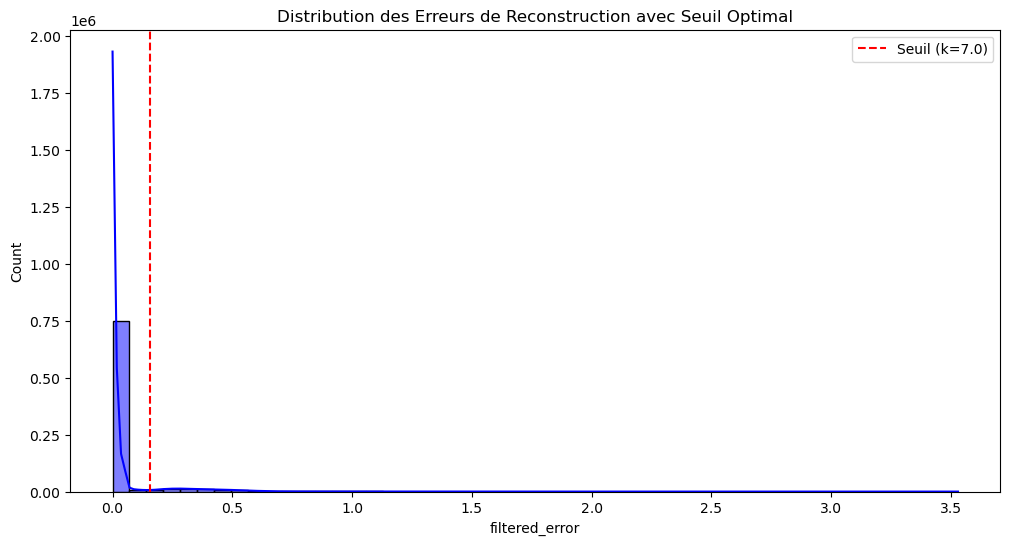

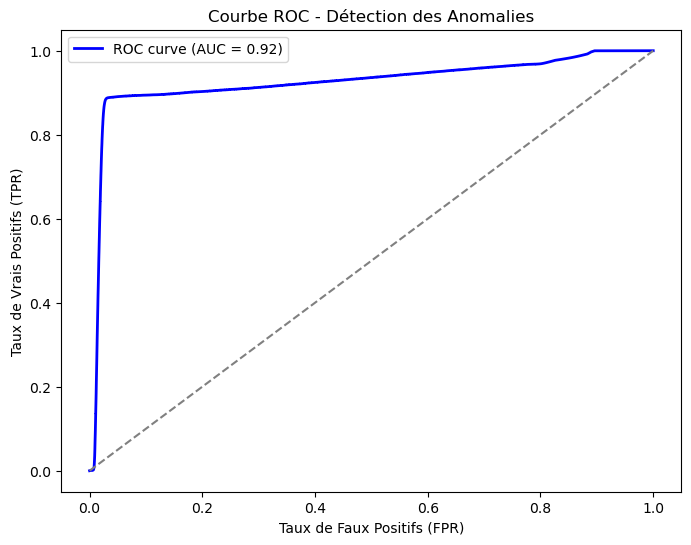

In [26]:
# Définition de la fenêtre avant panne (optimale = 30 min)
time_window = pd.Timedelta(minutes=30)

# Vérification et création de la colonne 'error' si elle n'existe pas
if "error" not in df.columns:
    df["error"] = df["DV_pressure"].diff().abs()  # Exemple : variation absolue de la pression
   
# Remplacer les NaN dans "error"
df["error"] = df["error"].fillna(0)  # Alternative : df["error"].fillna(df["error"].median())

# **Appliquer un Filtre Passe-Bas (LPF)**
def low_pass_filter(data, alpha=0.1):
    filtered_data = []
    prev = data.iloc[0]  # Utilisation du premier élément comme valeur initiale
    for point in data:
        new_value = prev + alpha * (point - prev)
        filtered_data.append(new_value)
        prev = new_value
    return pd.Series(filtered_data, index=data.index)  # Retourne une Series pour éviter le décalage d’index

# Appliquer le filtre LPF sur l’erreur détectée
df["filtered_error"] = low_pass_filter(df["error"], alpha=0.1)

# **Définition du seuil optimal (k=60)**
Q1 = df["filtered_error"].quantile(0.25)
Q3 = df["filtered_error"].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 60 * IQR  # Seuil ajusté

# **Détection des anomalies après application du LPF**
df["anomaly"] = df["filtered_error"] > threshold

# **Analyse des performances**
total_anomalies = df["anomaly"].sum()
anomalies_avant_panne = 0
detection_avant_panne = {}

# Analyse des anomalies avant chaque panne avec une fenêtre de 30 min
for panne in pannes:
    start_panne = pd.to_datetime(panne["start"])
    pre_panne = start_panne - time_window
    
    # Filtrer les anomalies détectées dans la période avant la panne
    anomalies = df[(df["timestamp"] >= pre_panne) & (df["timestamp"] < start_panne) & (df["anomaly"])]
    nb_anomalies = anomalies.shape[0]
    
    detection_avant_panne[start_panne] = nb_anomalies
    anomalies_avant_panne += (nb_anomalies > 0)  # Compte le nombre de pannes détectées

# Calcul des taux
taux_detection_pannes = (anomalies_avant_panne / len(pannes)) * 100
taux_faux_positifs = df[(df["anomaly"]) & (df["panne"] == 0)].shape[0] / total_anomalies * 100

# **Calcul des métriques de classification**
y_true = df["panne"] > 0  # 1 si panne, 0 sinon
y_pred = df["anomaly"]  # 1 si anomalie détectée, 0 sinon

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# **Courbe ROC et AUC**
fpr, tpr, _ = roc_curve(y_true, df["filtered_error"])
roc_auc = auc(fpr, tpr)

# **Comptage des anomalies par type de période**
anomalies_par_type = df.groupby("panne")["anomaly"].mean() * 100

# **Affichage des résultats**
print("-------------------------------------------------------------------")
for start_panne, nb_anomalies in detection_avant_panne.items():
    print(f"Période avant panne {start_panne}: {nb_anomalies} anomalies détectées")

print("-------------------------------------------------------------------")
print(f"Nombre total d’anomalies détectées : {total_anomalies}")
print(f"Taux de détection des anomalies avant les pannes : {taux_detection_pannes:.2f}%")
print(f"Taux de faux positifs : {taux_faux_positifs:.2f}%")
print("-------------------------------------------------------------------")
print(f"**Métriques de classification**")
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"Score F1 : {f1:.2f}")
print(f"AUC ROC : {roc_auc:.2f}")
print("-------------------------------------------------------------------")

# **Affichage des taux d’anomalies par type de période**
print("Période (panne)  Taux d’anomalies détectées")
for key, value in anomalies_par_type.items():
    label = "Normal" if key == 0 else "Panne" if key == 1 else "Pré-Panne"
    print(f"     {key} ({label})                      {value:.2f}%")

# **Visualisation des erreurs et des anomalies détectées**
plt.figure(figsize=(12,6))
sns.histplot(df["filtered_error"], bins=50, kde=True, color="blue")
plt.axvline(threshold, color='red', linestyle='--', label=f"Seuil (k=7.0)")
plt.legend()
plt.title("Distribution des Erreurs de Reconstruction avec Seuil Optimal")
plt.show()

# **Courbe ROC**
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC - Détection des Anomalies")
plt.legend()
plt.show()

In [1]:
import pandas as pd

# Création du DataFrame
data = {
    "k": [5, 10, 20, 30, 40, 50, 60, 70, 80],
    "Précision": [0.30, 0.32, 0.57, 0.61, 0.64, 0.66, 0.68, 0.69, 0.70],
    "Rappel": [0.90, 0.90, 0.89, 0.89, 0.89, 0.89, 0.88, 0.86, 0.82],
    "Score F1": [0.45, 0.47, 0.69, 0.72, 0.74, 0.76, 0.77, 0.77, 0.76],
    "Taux de faux positifs": ["70.22 %", "68.12 %", "43.46 %", "39.17 %", "36.22 %", "33.85 %", "31.96 %", "30.60 %", "29.90 %"],
    "Taux de détection pré-panne": ["35.36 %", "34.95 %", "28.40 %", "28.19 %", "28.19 %", "28.19 %", "28.19 %", "28.05 %", "27.58 %"],
}

df = pd.DataFrame(data)

# Affichage du DataFrame
display(df)


,k,Précision,Rappel,Score F1,Taux de faux positifs,Taux de détection pré-panne
0,5,0.30,0.90,0.45,70.22 %,35.36 %
1,10,0.32,0.90,0.47,68.12 %,34.95 %
2,20,0.57,0.89,0.69,43.46 %,28.40 %
3,30,0.61,0.89,0.72,39.17 %,28.19 %
4,40,0.64,0.89,0.74,36.22 %,28.19 %
5,50,0.66,0.89,0.76,33.85 %,28.19 %
6,60,0.68,0.88,0.77,31.96 %,28.19 %
7,70,0.69,0.86,0.77,30.60 %,28.05 %
8,80,0.70,0.82,0.76,29.90 %,27.58 %
